In [26]:
import warnings

warnings.filterwarnings('ignore')
import numpy
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import shutil
import glob

import random
from google.colab.patches import cv2_imshow
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D ,BatchNormalization,GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.applications.mobilenet import MobileNet,preprocess_input
from tensorflow.keras.models import Model
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.models import load_model

from tensorflow.keras.applications.vgg16 import VGG16

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import itertools

from google.colab import files

#shutil.rmtree('/content/Train/')
	



In [2]:
uploaded = files.upload()


Saving CV.zip to CV.zip
Saving Test.zip to Test.zip
Saving Train.zip to Train.zip


In [ ]:
!unzip /content/CV.zip
!unzip /content/Train.zip
!unzip /content/Test.zip

In [4]:
#count images according to classes 
pathTrain="/content/Train/"
pathCV = "/content/Test/"
pathTest="/content/CV/"

numberOfTrain = {}
numberOfCV = {}
numberOfTest={}

images_train_data={}
images_CV_data={}
images_Test_data={}


pathOfEachTrain=[]
pathOfEachCV=[]
pathOfEachtest=[]

for dir in os.listdir(pathTrain):
  images_train_data[dir]=os.listdir(os.path.join(pathTrain,dir))
  pathOfEachTrain.append(os.path.join(pathTrain,dir))
  numberOfTrain[dir] = len(os.listdir(os.path.join(pathTrain,dir)))
for dir in os.listdir(pathCV):
  images_CV_data[dir]=os.listdir(os.path.join(pathCV,dir))
  pathOfEachCV.append(os.path.join(pathCV,dir))
  numberOfCV[dir] = len(os.listdir(os.path.join(pathCV,dir)))
for dir in os.listdir(pathTest):
  images_Test_data[dir]=os.listdir(os.path.join(pathTest,dir))
  pathOfEachtest.append(os.path.join(pathTest,dir))
  numberOfTest[dir] = len(os.listdir(os.path.join(pathTest,dir)))


In [5]:
#data augm train
trainGen = ImageDataGenerator(
                             vertical_flip=True,
                             rescale=1/255

                             )

Train_prepare = trainGen.flow_from_directory(directory = pathTrain,target_size=(224,224),batch_size=32,class_mode='binary')
image1=cv2.imread(Train_prepare.filepaths[100])
image2=cv2.imread(Train_prepare.filepaths[1000])

Found 1515 images belonging to 2 classes.


Found 233 images belonging to 2 classes.
Found 233 images belonging to 2 classes.


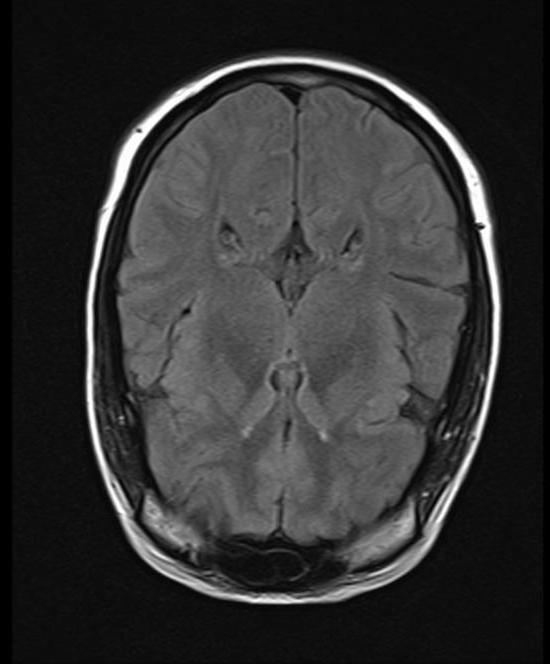

In [6]:
datagen = ImageDataGenerator(
                             rescale=1/255
                             )
test_prepare = datagen.flow_from_directory(directory = pathTest,target_size=(224,224),batch_size=7,class_mode='binary')
test_prepare

CV_prepare = datagen.flow_from_directory(directory = pathCV,target_size=(224,224),batch_size=6,class_mode='binary')
CV_prepare



In [7]:
es = EarlyStopping(monitor="val_accuracy",min_delta=0.01,patience=6,verbose=1,mode='auto')
mc = ModelCheckpoint(monitor="val_accuracy",filepath="mymodel.h5",save_best_only=True,verbose=1,mode='auto') 
cd=[es,mc] 


In [8]:
MN = MobileNet(input_shape=(224,224,3),include_top=False)

17225924/17225924 [==============================] - 2s 0us/step


In [9]:
for layer in MN.layers:
    layer.trainable = False

In [10]:
Out = Flatten()(MN.output)
Out = Dense(1,activation='sigmoid')(Out)

In [11]:

model = Model(inputs = MN.input,outputs=Out)
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                                      

In [12]:
model.compile(
    loss=binary_crossentropy,
    metrics=['accuracy'],
    optimizer=Adam(0.001)
)

In [ ]:
final=model.fit_generator(generator=Train_prepare
                          ,steps_per_epoch=8
                          ,epochs=30
                          ,verbose=1
                          ,validation_data=CV_prepare
                          ,validation_steps=16
                          ,callbacks=cd)

In [14]:
f=final.history
print(f.keys())
print(max(f['accuracy']))
print(max(f['val_accuracy']))

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
1.0
1.0


In [15]:
model = load_model("/content/mymodel.h5")

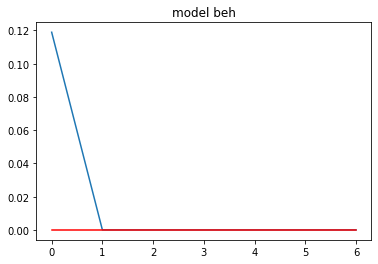

In [16]:
plt.plot(f['loss'])
plt.plot(f['val_loss'],c="red")
plt.title("model beh")
plt.show()


In [17]:
#acc
acc=model.evaluate_generator(test_prepare)[1]
print(f"the accuracy is {acc*100} %")

the accuracy is 100.0 %


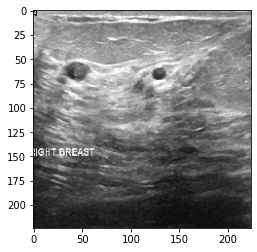

1/1 [==============================] - 1s 534ms/step
[[1.]]
breast


In [18]:
path = "/content/Test/breast/benign (4).png"
img = load_img(path,target_size=(224,224))
input_arr = img_to_array(img)/255
plt.imshow(input_arr)
plt.show()
input_arr=np.expand_dims(input_arr,axis=0)
pred=model.predict(input_arr)
print(pred)
if pred>0.5:
  print("breast")
else:
  print("brain")


In [19]:
model =  Sequential(
    [
        Conv2D(filters = 16,kernel_size=(3,3),activation='relu',input_shape=(224,224,3)),
        Conv2D(filters = 36,kernel_size=(3,3),activation='relu'),
        MaxPooling2D(pool_size=(2,2)),
        Conv2D(filters = 64,kernel_size=(3,3),activation='relu'),
        MaxPooling2D(pool_size=(2,2)),
        Conv2D(filters = 128,kernel_size=(3,3),activation='relu'),
        MaxPooling2D(pool_size=(2,2)),
        Dropout(rate=0.25),
        Flatten(),
        




     
        Dense(64, activation="relu"),
        Dropout(rate=0.25),
        Dense(1 , activation= 'sigmoid')
    ], name="Complex"
)
es = EarlyStopping(monitor="val_accuracy",min_delta=0.01,patience=6,verbose=1,mode='auto')
mc = ModelCheckpoint(monitor="val_accuracy",filepath="BvsB.h5",save_best_only=True,verbose=1,mode='auto') 
cd=[es,mc] 



In [20]:
model.compile(
    loss=binary_crossentropy,
    metrics=['accuracy'],
    optimizer=Adam(0.001)
)

In [21]:
final=model.fit_generator(generator=Train_prepare
                          ,steps_per_epoch=8
                          ,epochs=30
                          ,verbose=1
                          ,validation_data=CV_prepare
                          ,validation_steps=16
                          ,callbacks=cd)

Epoch 1/30
8/8 [==============================] - ETA: 0s - loss: 0.4821 - accuracy: 0.6875
Epoch 1: val_accuracy improved from -inf to 0.97917, saving model to BvsB.h5
8/8 [==============================] - 5s 314ms/step - loss: 0.4821 - accuracy: 0.6875 - val_loss: 0.3002 - val_accuracy: 0.9792
Epoch 2/30
8/8 [==============================] - ETA: 0s - loss: 0.1599 - accuracy: 0.9805
Epoch 2: val_accuracy improved from 0.97917 to 0.98958, saving model to BvsB.h5
8/8 [==============================] - 2s 291ms/step - loss: 0.1599 - accuracy: 0.9805 - val_loss: 0.0210 - val_accuracy: 0.9896
Epoch 3/30
8/8 [==============================] - ETA: 0s - loss: 0.1635 - accuracy: 0.9648
Epoch 3: val_accuracy did not improve from 0.98958
8/8 [==============================] - 2s 264ms/step - loss: 0.1635 - accuracy: 0.9648 - val_loss: 0.0500 - val_accuracy: 0.9792
Epoch 4/30
8/8 [==============================] - ETA: 0s - loss: 0.0664 - accuracy: 0.9805
Epoch 4: val_accuracy did not improve

In [22]:
model = load_model("/content/mymodel.h5")
f=final.history
print(f.keys())
print(max(f['accuracy']))
print(max(f['val_accuracy']))

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
1.0
1.0


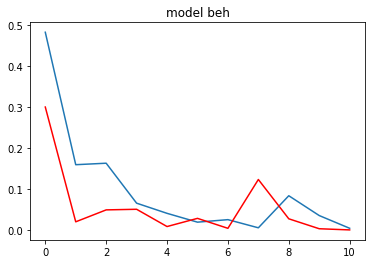

In [23]:
plt.plot(f['loss'])
plt.plot(f['val_loss'],c="red")
plt.title("model beh")
plt.show()


In [24]:
#acc
acc=model.evaluate_generator(test_prepare)[1]
print(f"the accuracy is {acc*100} %")

the accuracy is 100.0 %


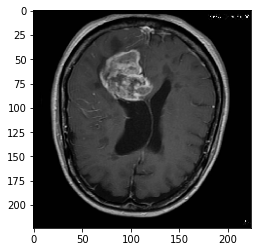

1/1 [==============================] - 0s 350ms/step
[[2.4197806e-18]]
brain


In [25]:
path = "/content/Test/brain/y789.jpg"
img = load_img(path,target_size=(224,224))
input_arr = img_to_array(img)/255
plt.imshow(input_arr)
plt.show()
input_arr=np.expand_dims(input_arr,axis=0)
pred=model.predict(input_arr)
print(pred)
if pred>0.5:
  print("breast")
else:
  print("brain")
